In [105]:
import mysql.connector
import pandas as pd
mydb = mysql.connector.connect(
     host = "mdsi-dsp-spr-2020.cehiwpryiego.ap-southeast-2.rds.amazonaws.com",
     port = "3306",
     user = "min", ## Change as required
     password = "utsmdsi2020",
     database = "asx")

mycursor = mydb.cursor()
print('Database Open')

Database Open


In [106]:
#join vix index to asx200 index monthly
df = pd.read_sql_query("SELECT * FROM asx.vix where Date > 2004-01-02", con=mydb)
print(df)
df_asx = pd.read_sql_query("SELECT * FROM asx.asx_s_and_p where date > '2004-01-02'", con=mydb)
print(df_asx)
df_comparison = pd.merge(df_asx,df,left_on='date', right_on='Date')

            Date   Open   High    Low  Close
0     2004-01-02  17.96  18.68  17.54  18.22
1     2004-01-05  18.45  18.49  17.44  17.49
2     2004-01-06  17.66  17.67  16.19  16.73
3     2004-01-07  16.72  16.75  15.50  15.50
4     2004-01-08  15.42  15.68  15.32  15.61
...          ...    ...    ...    ...    ...
4206  2020-09-17  28.22  28.92  26.26  26.46
4207  2020-09-18  26.65  28.10  25.28  25.83
4208  2020-09-21  28.04  31.18  27.39  27.78
4209  2020-09-22  28.61  28.78  26.48  26.86
4210  2020-09-23  27.02  29.73  25.19  28.58

[4211 rows x 5 columns]
           date     asx_open  s_and_p_open
0    2004-02-01  3273.199951   1131.130005
1    2004-03-01  3364.800049   1144.939941
2    2004-04-01  3418.699951   1126.209961
3    2004-05-01  3399.000000   1107.300049
4    2004-06-01  3459.300049   1120.680054
..          ...          ...           ...
197  2020-07-01  5897.899902   3105.919922
198  2020-08-01  5927.799805   3288.260010
199  2020-09-01  6060.500000   3507.439941
200  

In [107]:
#select 3 column - date, asx_open and vix close
df_comparison = df_comparison[["date","asx_open","Close"]]
print(df_comparison)

           date     asx_open  Close
0    2004-03-01  3364.800049  14.44
1    2004-04-01  3418.699951  16.65
2    2004-06-01  3459.300049  16.30
3    2004-07-01  3533.000000  15.20
4    2004-09-01  3554.000000  14.91
..          ...          ...    ...
124  2020-04-01  5076.799805  57.06
125  2020-05-01  5522.399902  37.19
126  2020-06-01  5755.700195  28.23
127  2020-07-01  5897.899902  28.62
128  2020-09-01  6060.500000  26.12

[129 rows x 3 columns]


In [108]:
#test correlation of date matched two indexes, cor = -0.27965
import scipy.stats as stats
print(stats.pearsonr(df_comparison.asx_open,df_comparison.Close))

(-0.27965113679101067, 0.001329203137223191)


In [110]:
#test whether correlation is stronger if taking vix month n increase vs. asx month n+1 increase, result is cor = -0.0311
#correlation is close to none
df_comparison["asx_increase"] = (df_comparison.asx_open - df_comparison.asx_open.shift(1))/df_comparison.asx_open.shift(1)
df_comparison["vix_increase"] = (df_comparison.Close.shift(1) - df_comparison.Close.shift(2))/df_comparison.Close.shift(2)
df_comparison = df_comparison.dropna()
print(stats.pearsonr(df_comparison.asx_increase,df_comparison.vix_increase))

(-0.031125993371113995, 0.7304051859432971)


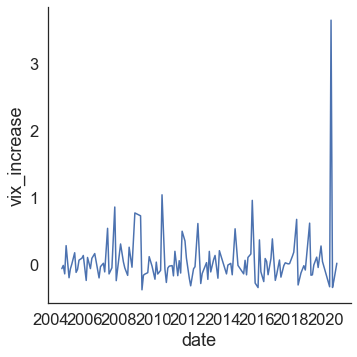

In [111]:
#visualise the vix index by date
import seaborn as sns
sns.relplot(x="date", y="vix_increase", sort=False, kind="line", data=df_comparison)

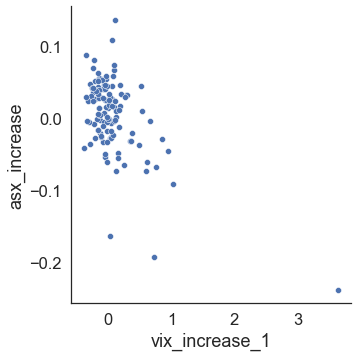

In [112]:
#visualise the asx index increase rate vs. vix index increase rate
df_comparison["vix_increase_1"] = (df_comparison.Close - df_comparison.Close.shift(1))/df_comparison.Close.shift(1)
df_comparison_1 = df_comparison.dropna()
sns.relplot(x="vix_increase_1", y="asx_increase", kind="scatter", data=df_comparison_1)

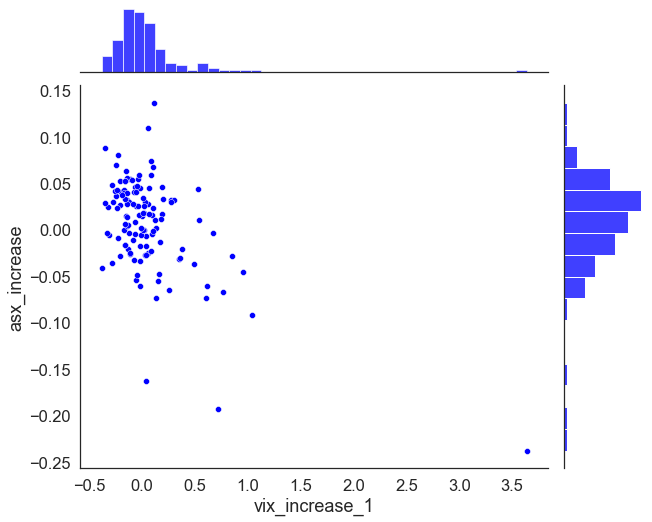

In [113]:
#visualise the scatter and frequency for two indexes
sns.set(style="white",font_scale=1.5)
g = sns.jointplot(x='vix_increase_1', y='asx_increase', data=df_comparison_1,
                 color='blue',
                 )
g.fig.set_size_inches(10,8)

In [114]:
# query on Australian GDP history and check the GDP growth % for each year
gdp = round(pd.read_sql_query("SELECT Year, GDP_per_cap, GDP_growth_perc FROM GDP_history_year", con=mydb),2)
gdp['Year'] = pd.to_datetime(gdp_per_cap['Year'], format = '%Y-%m-%d')
gdp['GDP_growth_YoY'] = gdp['GDP_growth_perc'] - gdp['GDP_growth_perc'].shift(1)

# round the growth % and YoY % to prepare the group analysis
gdp['GDP_growth_round'] = gdp['GDP_growth_perc'].round()
gdp['GDP_YoY_round'] = gdp['GDP_growth_YoY'].round()

gdp.drop(gdp.tail(1).index,inplace=True)

In [115]:
# calculate ASX200 index average dailychange %rate by year
import numpy as np
import pandas as pd
import datetime as dt
import warnings
warnings.filterwarnings('ignore')

df_comparison_1['yr'] = df_comparison_1['date'].apply(lambda x: x.year)
df_sum = df_comparison_1[['yr','asx_increase']].groupby(['yr']).agg([np.mean])
df_sum.columns=['asx_mean_increase']

In [116]:
# calculate GDP growth by year
gdp['yr'] = gdp['Year'].apply(lambda x: x.year)
print(gdp[gdp.yr >= 2004])

         Year  GDP_per_cap  GDP_growth_perc  GDP_growth_YoY  GDP_growth_round  \
33 2004-01-01     30430.68             4.06            1.07               4.0   
34 2005-01-01     33999.24             3.20           -0.86               3.0   
35 2006-01-01     36044.92             2.79           -0.41               3.0   
36 2007-01-01     40960.05             3.84            1.05               4.0   
37 2008-01-01     49601.66             3.66           -0.18               4.0   
38 2009-01-01     42772.36             1.94           -1.72               2.0   
39 2010-01-01     52022.13             2.07            0.13               2.0   
40 2011-01-01     62517.83             2.46            0.39               2.0   
41 2012-01-01     68012.15             3.92            1.46               4.0   
42 2013-01-01     68150.11             2.58           -1.34               3.0   
43 2014-01-01     62510.79             2.53           -0.05               3.0   
44 2015-01-01     56755.72  

In [117]:
#join gdp and asx200 by year
asx200_gdp_comparison = pd.merge(df_sum,gdp, on="yr", how='left')
asx200_gdp_comparison.drop(asx200_gdp_comparison.tail(1).index,inplace=True)

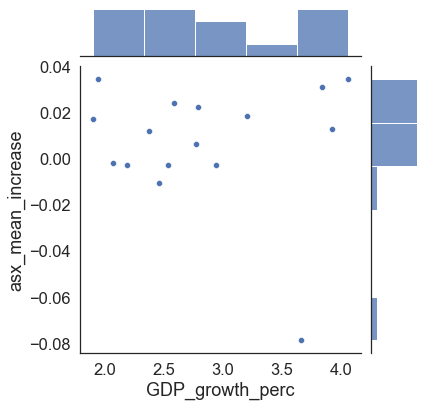

In [118]:
sns.jointplot("GDP_growth_perc", 
              "asx_mean_increase",
              data=asx200_gdp_comparison)

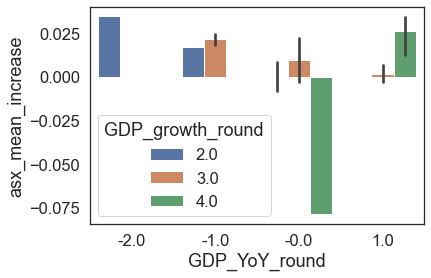

In [119]:
sns.barplot(x="GDP_YoY_round", y="asx_mean_increase", hue="GDP_growth_round",data=asx200_gdp_comparison)

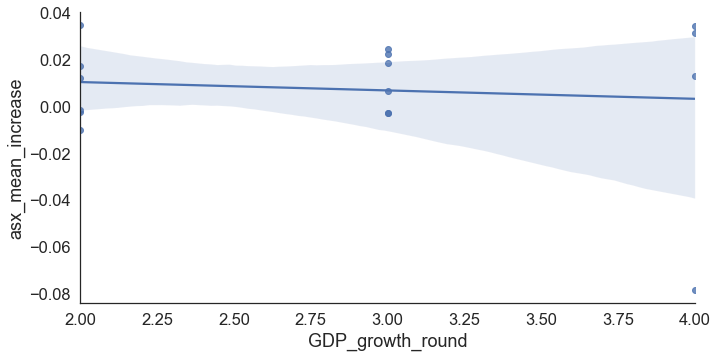

In [120]:
g = sns.lmplot(x="GDP_growth_round",
               y="asx_mean_increase",
               data=asx200_gdp_comparison,
               aspect=2)
g = (g.set_axis_labels("GDP_growth_round","asx_mean_increase"))
plt.show(g)